# Examples of Continuous Wavelet

Author: Patrice Fortin

Date: 2025-01-06

The following Jupyter Notebook gives code examples for inspecting the internals of the Wavelet Transform Coherence (WTC) by showing figures of different steps of the computation.

The figures can be used to visually inspect the differences between choices of parameters, and libraries.

HyPyP is expected to use Pywavelets as a default implementation. It is the recommended library to use for wavelet in python, and the one that offers the most flexibility. The Pywavelets library is the only one expected to be used in production code.

But, for the sake of validating the HyPyP implementation of WTC, 4 different libraries have been explored.


| Library | Runtime | Details |
| - | - | - |
| Pywavelets | python | The default. Should always be used for production code |
| Pycwt | python | Based on matlab's code |
| Scipy | python | Deprecated, without optimisation so easier to understand the library's code |
| WaveletCoherence | matlab | Calls matlab engine |



## Load libraries


In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
%load_ext IPython.extensions.autoreload
%autoreload 2

# To set breakpoints in a dependency library, use the following strategy
#import sys
#sys.path.insert(0, '/path/to/pycwt')
#import pycwt

import hypyp.fnirs as fnirs
from hypyp.wavelet.base_wavelet import DEFAULT_PERIODS_DJ
from hypyp.wavelet.wavelet_implementations.pywavelets_wavelet import PywaveletsWavelet
from hypyp.wavelet.wavelet_implementations.pycwt_wavelet import PycwtWavelet
from hypyp.wavelet.wavelet_implementations.scipy_wavelet import ScipyWavelet
from hypyp.wavelet.coherence_data_frame import CoherenceDataFrame
from hypyp.wavelet.cwt import CWT

## Download and load raw data from disk

To use as example, we download the dataset "Dataset of parent-child hyperscanning fNIRS recordings" from https://researchdata.ntu.edu.sg/dataset.xhtml?persistentId=doi:10.21979/N9/35DNCW

In [3]:
browser = fnirs.DataBrowser()
browser.download_demo_dataset()


'/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers'

Prepare a list of file paths to be used, without distinction of dyads or parent/child. For this example we just want some data.


In [4]:
# Get the paths of files

paths = [path for path in browser.list_all_files() if 'fathers' in path]

pattern = re.compile(r'.*/(parent|child)/.*')

file_paths = []
for path in paths:
    if pattern.match(path) is not None:
        file_paths.append(path)
    
if len(file_paths) == 0:
    raise RuntimeError('Cannot find a fNIRS file')

file_path = file_paths[0]

#print(file_path)
    

## Define the wavelets

We prepare a list of wavelets to be compared. We set the same periods_range for every wavelet.

Disabling the caching on wavelets is not mandatory here, but in the view that this code serves as an example, if one modifies this and reuse the same wavelet in different places without considering the fact that it caches results, one might see unexpected behaviour.

In [5]:
wavelet_kwargs = dict(disable_caching=True, periods_range=(1, 30))

wavelets = [
    PywaveletsWavelet(wavelet_name='cmor2,0.4', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cmor2,0.7', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cmor2,1', **wavelet_kwargs), # default
    PywaveletsWavelet(wavelet_name='cmor2,2', **wavelet_kwargs),

    PywaveletsWavelet(wavelet_name='cgau2', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cgau3', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cgau4', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cgau5', **wavelet_kwargs),

    ScipyWavelet(center_frequency=2, **wavelet_kwargs),
    ScipyWavelet(center_frequency=4, **wavelet_kwargs),
    ScipyWavelet(center_frequency=6, **wavelet_kwargs),
    ScipyWavelet(center_frequency=10, **wavelet_kwargs),

    PycwtWavelet(center_frequency=2, **wavelet_kwargs),
    PycwtWavelet(center_frequency=4, **wavelet_kwargs),
    PycwtWavelet(center_frequency=6, **wavelet_kwargs), # default
    PycwtWavelet(center_frequency=10, **wavelet_kwargs),
]



Prepare a python iterator to easily loop over each wavelet and have a handy ax object for grid plotting.

In [6]:
def wavelets_plot_iterator():
    cols = 4
    rows = int(np.ceil(len(wavelets) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    axes = np.atleast_2d(axes)
    for i, wavelet in enumerate(wavelets):
        row = i // cols
        col = i % cols
        ax = axes[row][col]
        yield wavelet, ax


### Mother wavelets

Let's compare mother wavelets. The x axis differs between libraries because of implementation details.

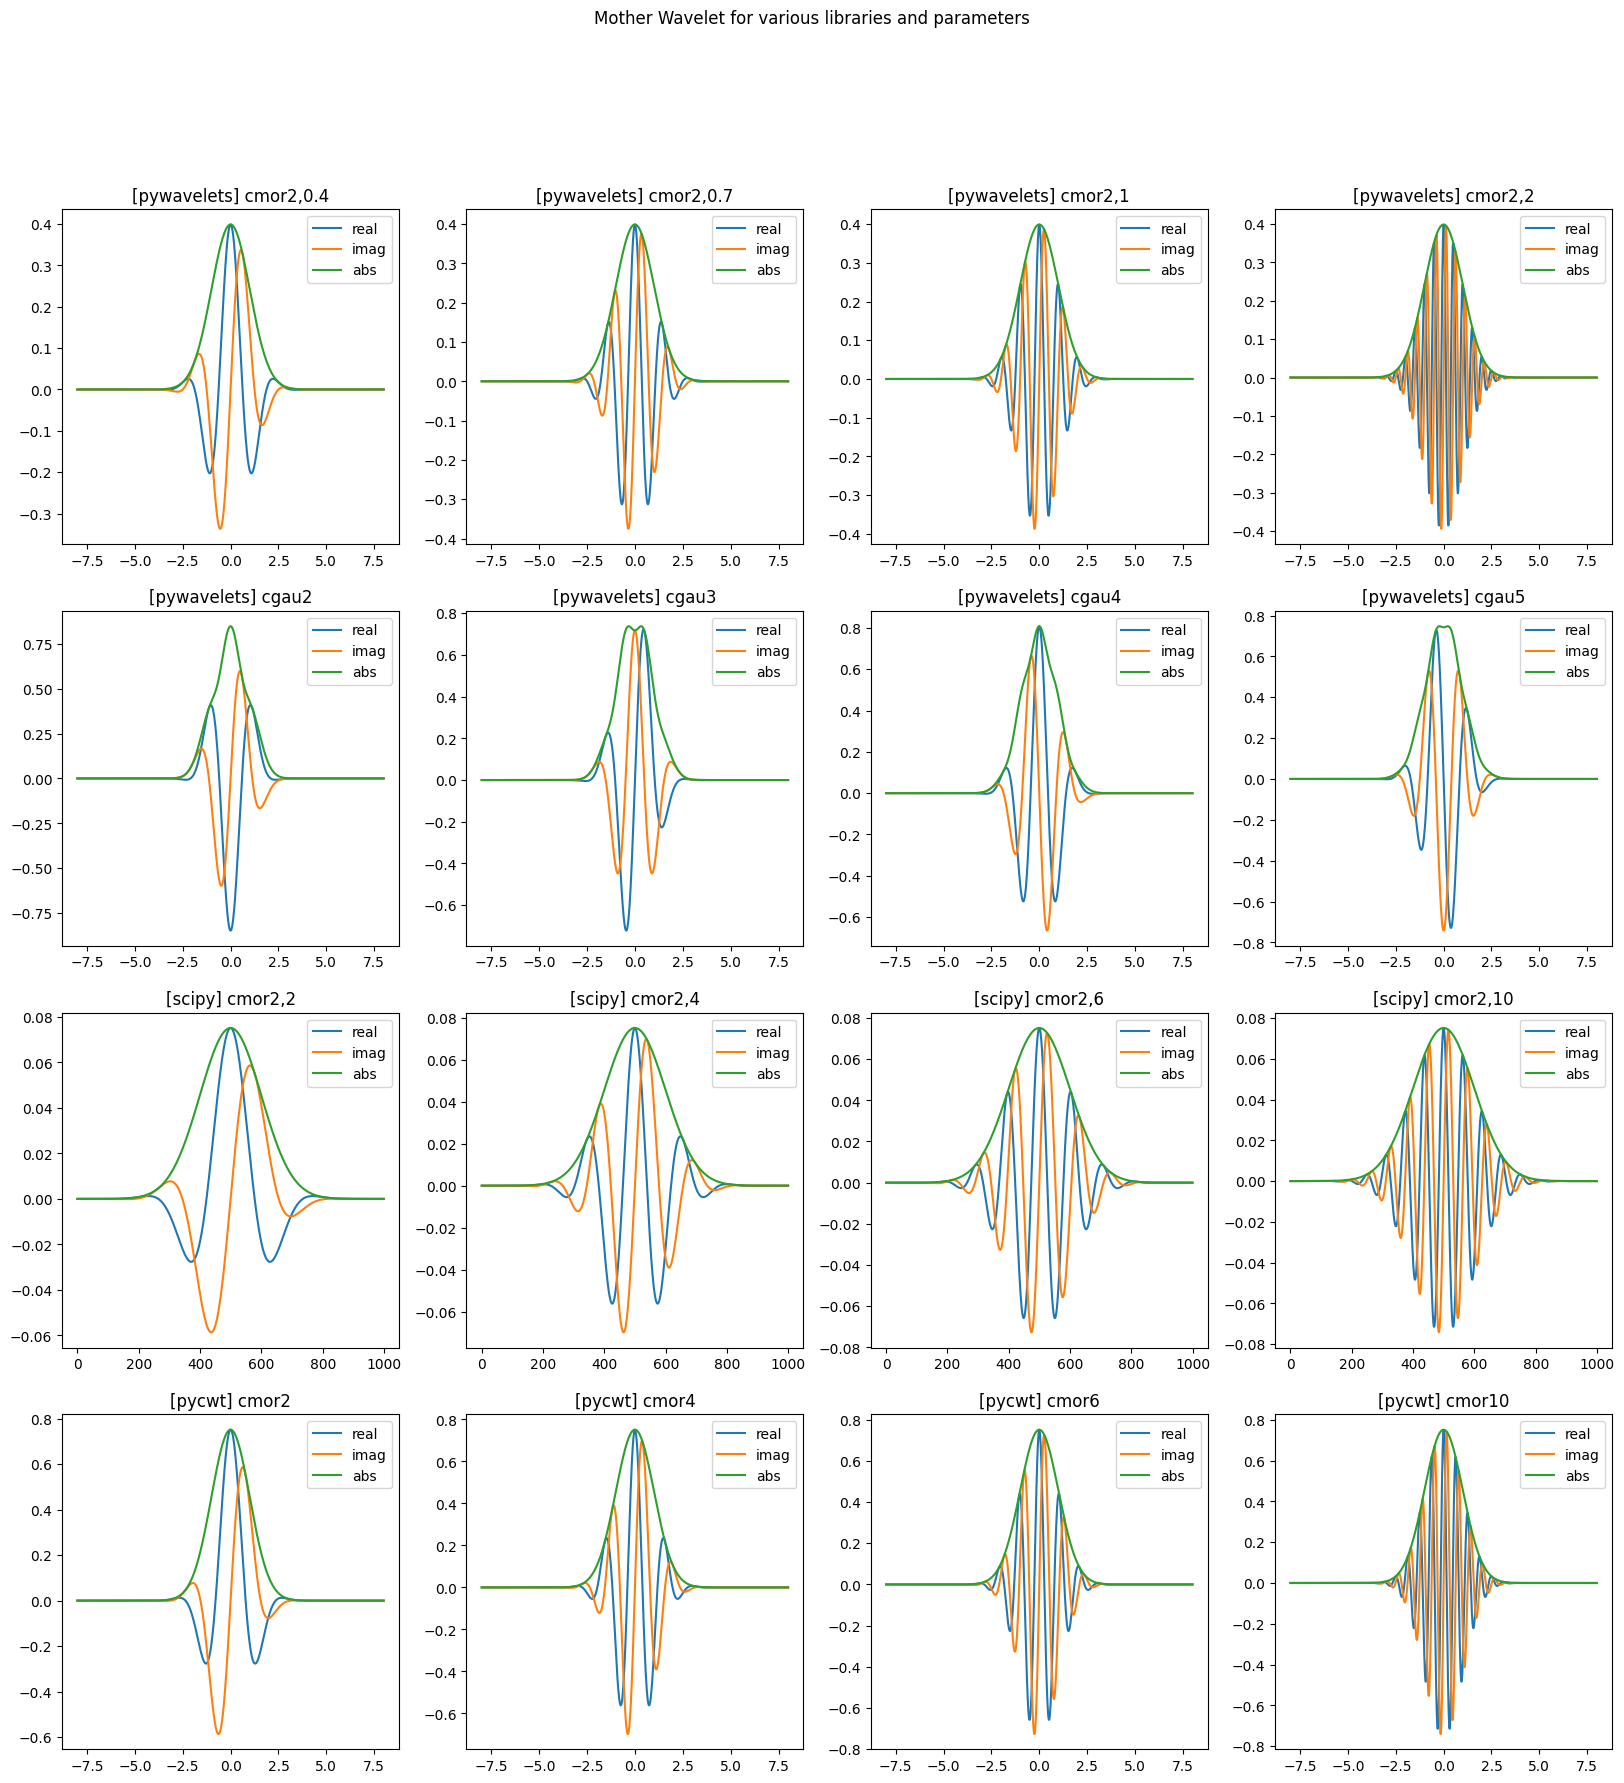

In [7]:

for wavelet, ax in wavelets_plot_iterator():
    wavelet.plot_mother_wavelet(ax=ax)
    ax.set_title(f'[{wavelet.wavelet_library}] {wavelet.wavelet_name}')
_ = ax.get_figure().suptitle('Mother Wavelet for various libraries and parameters')


### Form the dyad and channel pairs

Prepare the signals to be used in the Continuous Wavelet Transforms. We use the first 2 files and compare the pair of the first channel in both subject

In [8]:
tasks = [('sample', 60, 120)]
subject1 = fnirs.Subject(label='Subject1', tasks_time_range=tasks).load_file(file_paths[0], fnirs.MnePreprocessorBasic())
subject2 = fnirs.Subject(label='Subject2', tasks_time_range=tasks).load_file(file_paths[1], fnirs.MnePreprocessorBasic())
dyad = fnirs.Dyad(subject1, subject2, label=f'intra')
# take one pair
pair = dyad.get_pairs(subject1, subject2)[0]


Visualize the 2 signals


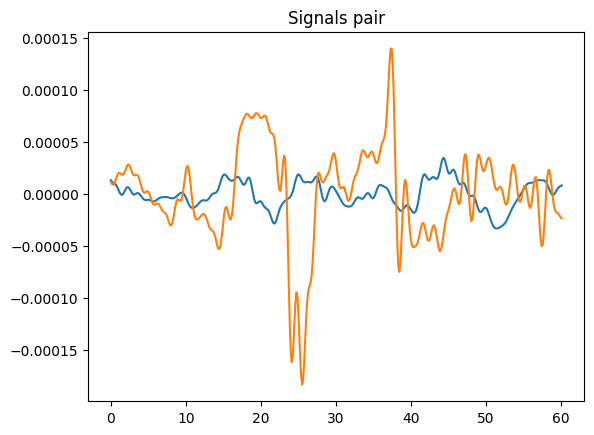

In [9]:
plt.plot(pair.x, pair.y1)
plt.plot(pair.x, pair.y2)
plt.title('Signals pair')
plt.show()


# Continuous Wavelet Transform (CWT)

We run the Continuous Wavelet Transform on both channels of the pair and visually inspect the results for every wavelet choices.

The darker area correspond to the Cone of Influence, for which periods greater than a certain value are more subject to artifacts. 

**NOTE: The computation of the Cone of Influence in the pywavelets should be reviewed for validity.**


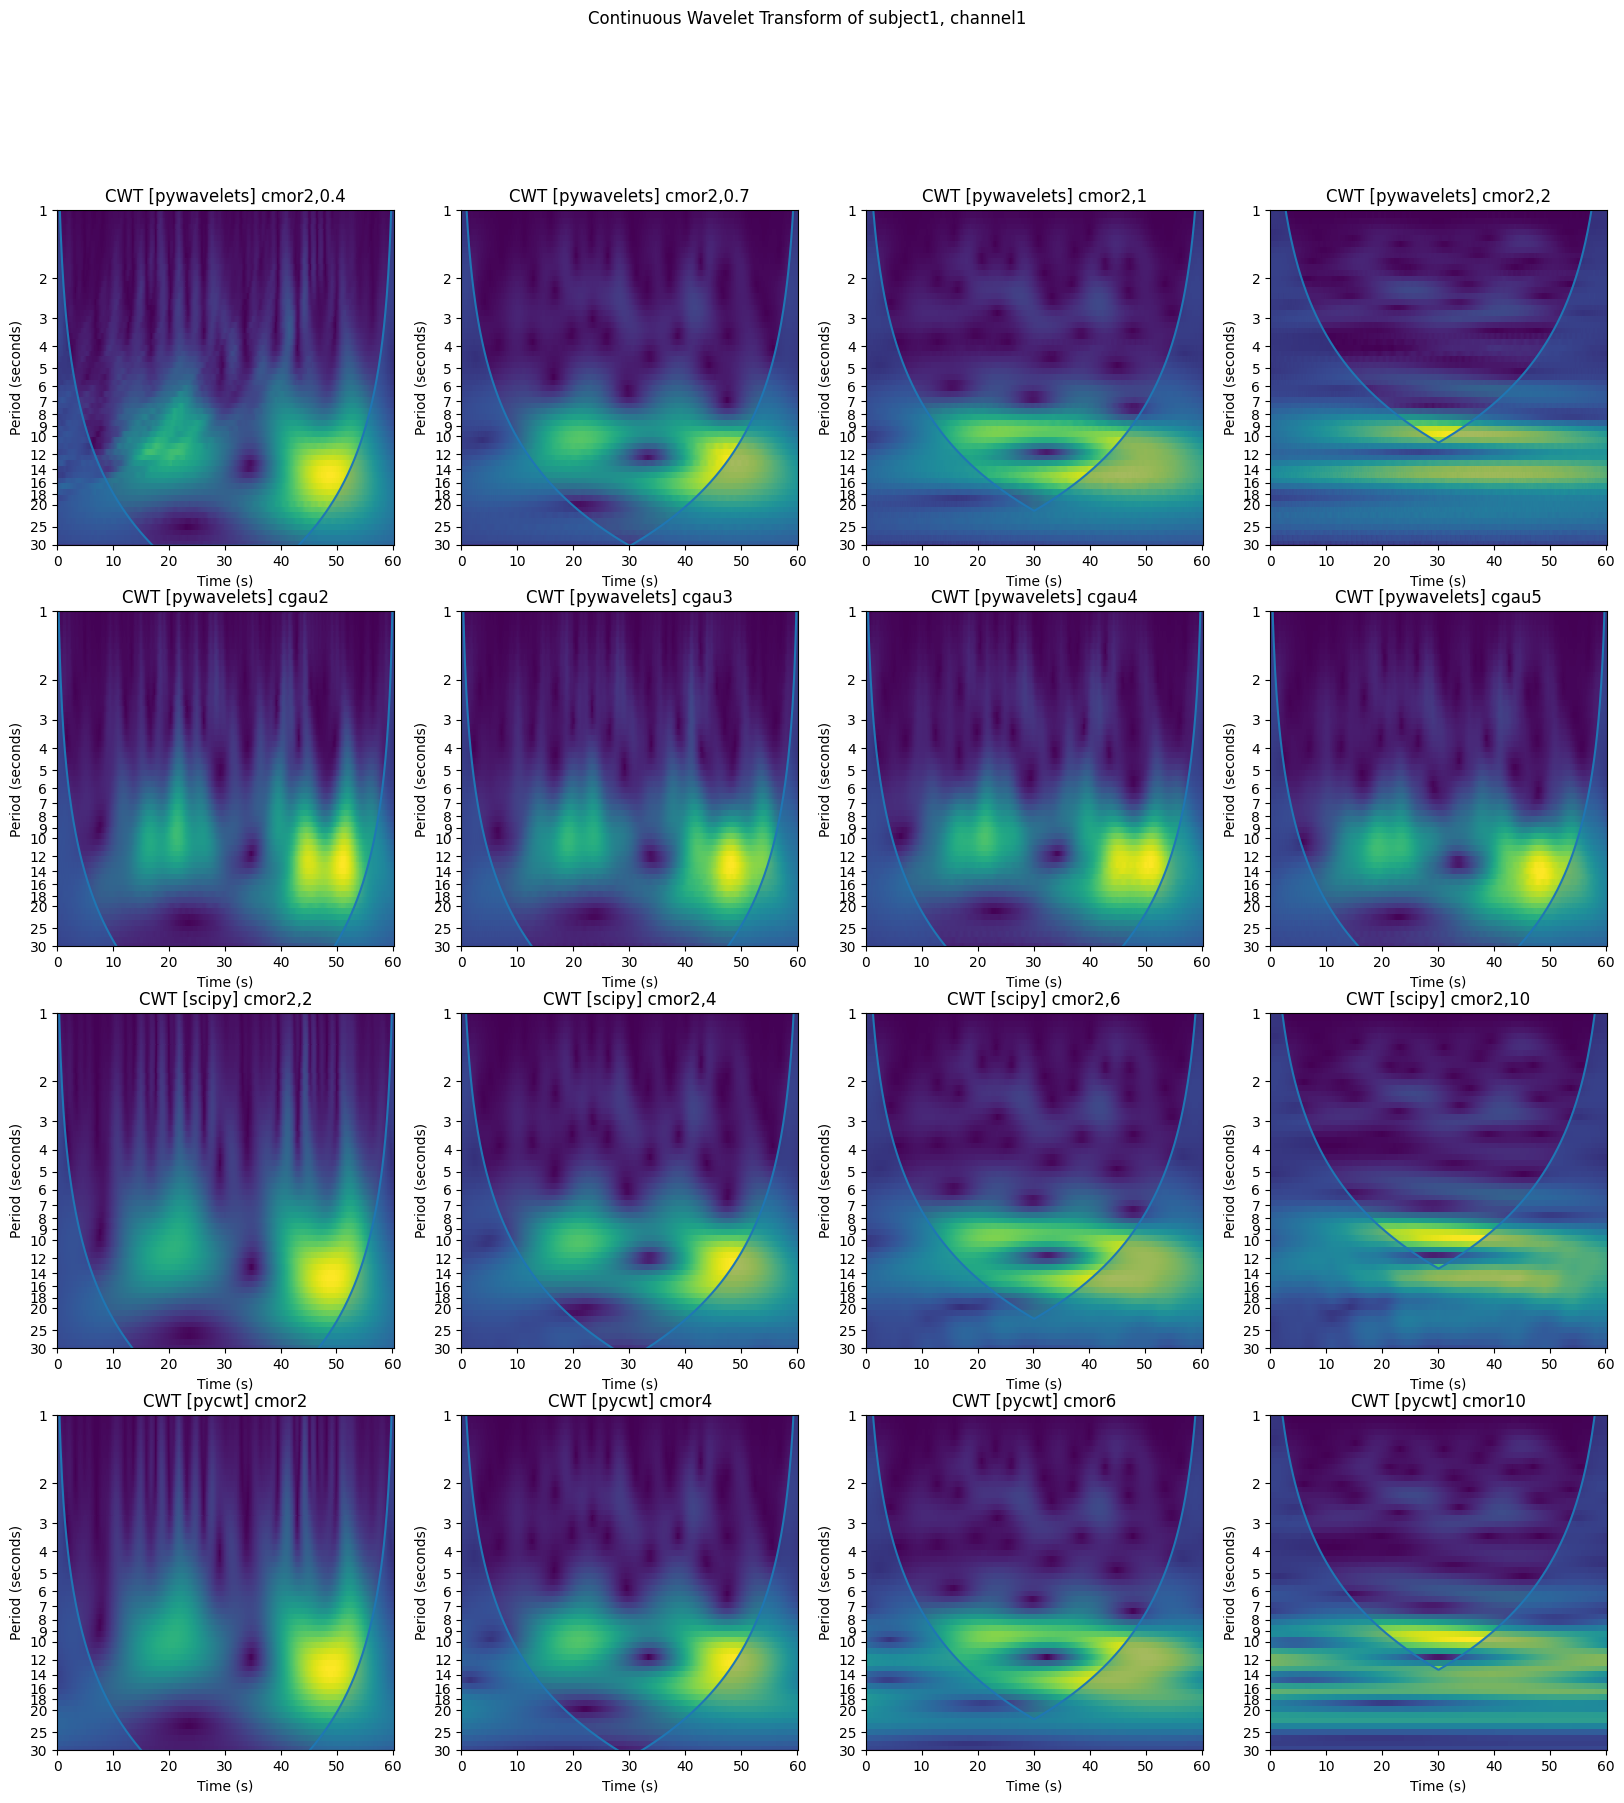

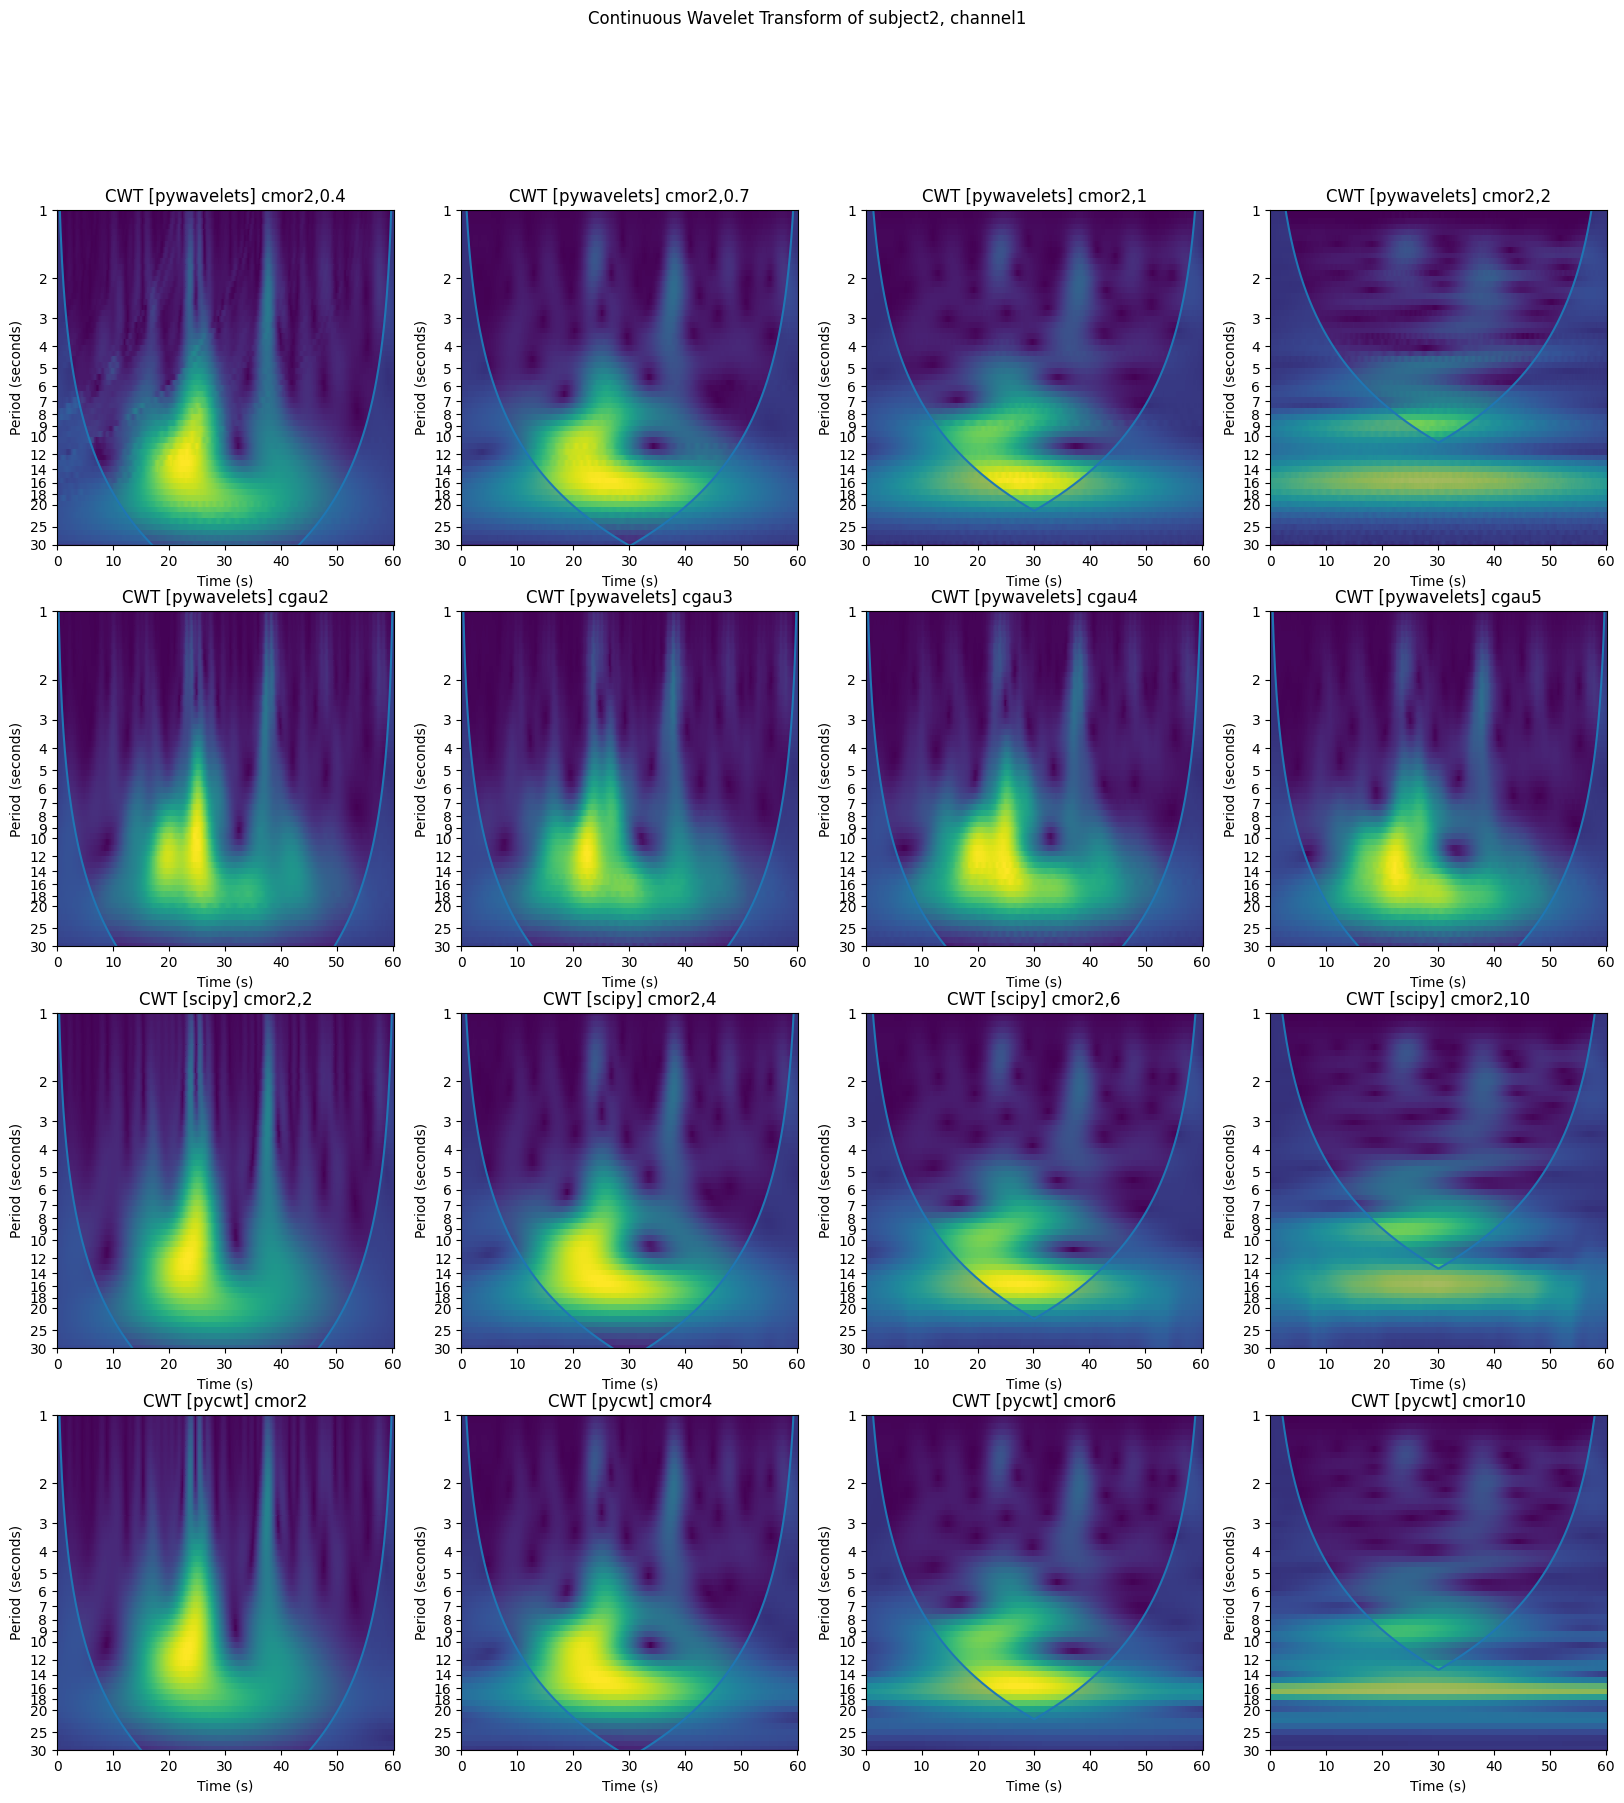

In [10]:
for wavelet, ax in wavelets_plot_iterator():
    cwt = wavelet.cwt(pair.y1, pair.dt)
    cwt.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'CWT [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
    ax.get_figure().suptitle('Continuous Wavelet Transform of subject1, channel1')
plt.show()

for wavelet, ax in wavelets_plot_iterator():
    cwt = wavelet.cwt(pair.y2, pair.dt)
    cwt.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'CWT [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
    ax.get_figure().suptitle('Continuous Wavelet Transform of subject2, channel1')
plt.show()

## Compare smoothed CWTs


We explore the smooting of the the CWT. The weights of the CWT are smooted both in time and in frequency. 

The code below replicates the implementation details in the `BaseWavelet` class.

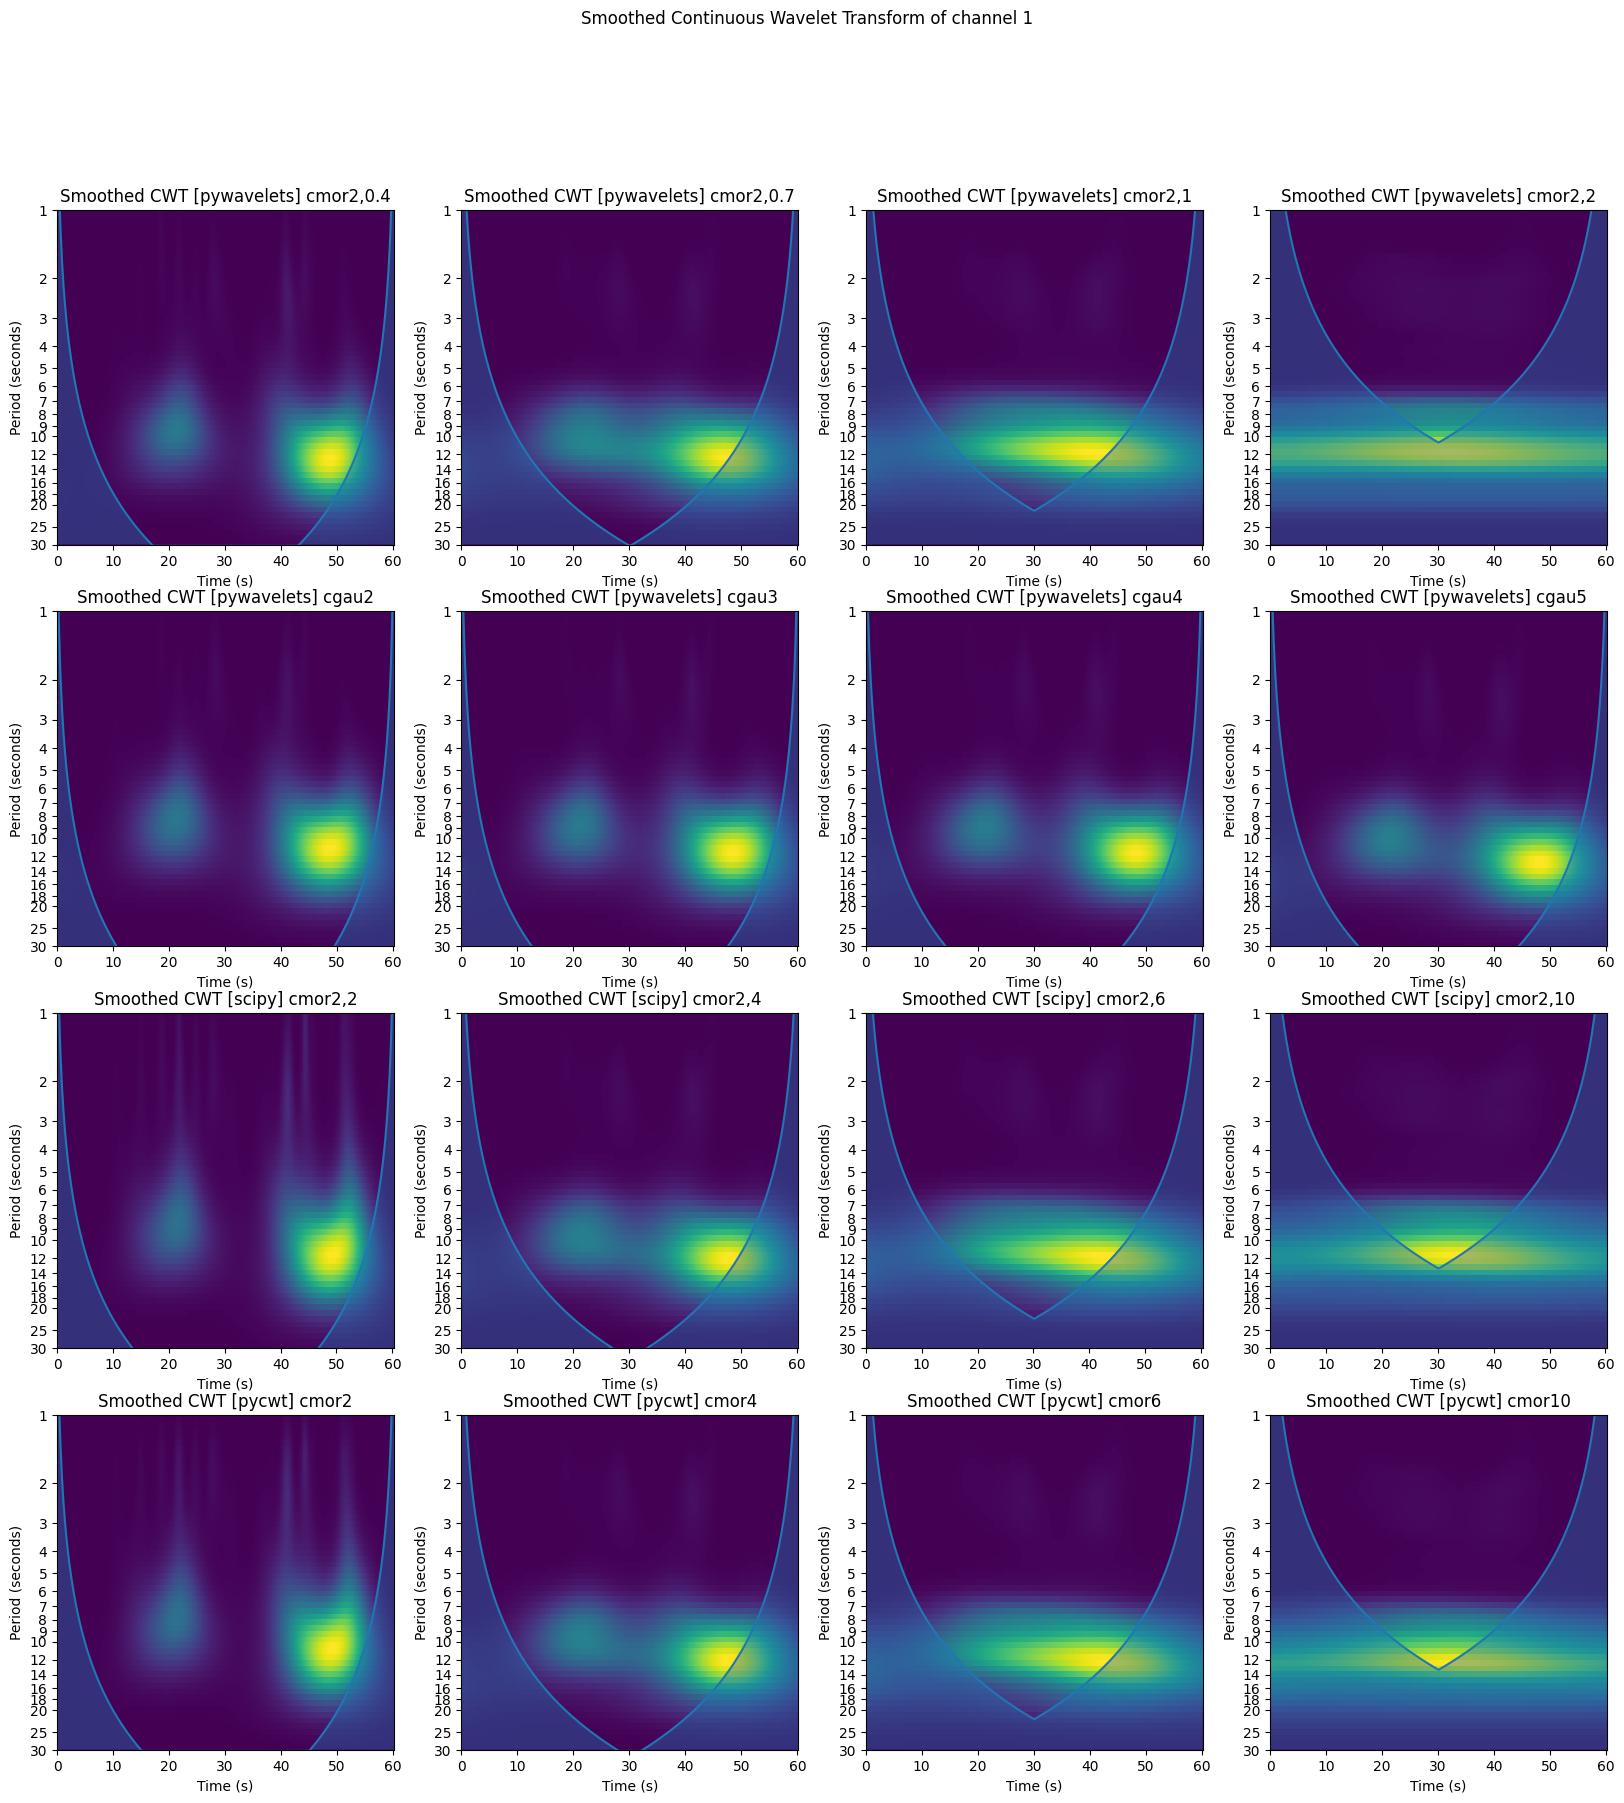

In [11]:
for wavelet, ax in wavelets_plot_iterator():
    cwt = wavelet.cwt(pair.y1, pair.dt)

    scales = np.ones([1, len(pair.y1)]) * cwt.scales[:, None]
    smooted = wavelet.smoothing(np.abs(cwt.W) ** 2 / scales, cwt.dt, DEFAULT_PERIODS_DJ, cwt.scales)
    cwt_smoothed = CWT(smooted**2, cwt.times, cwt.scales, cwt.periods, cwt.coi)
    cwt_smoothed.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'Smoothed CWT [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
    ax.get_figure().suptitle('Smoothed Continuous Wavelet Transform of channel 1')
plt.show()



## Compare Wavelet Transform Coherence (WTC)

Now that we can trust our CWT and smoothing, we compare the WTC results for each wavelet.

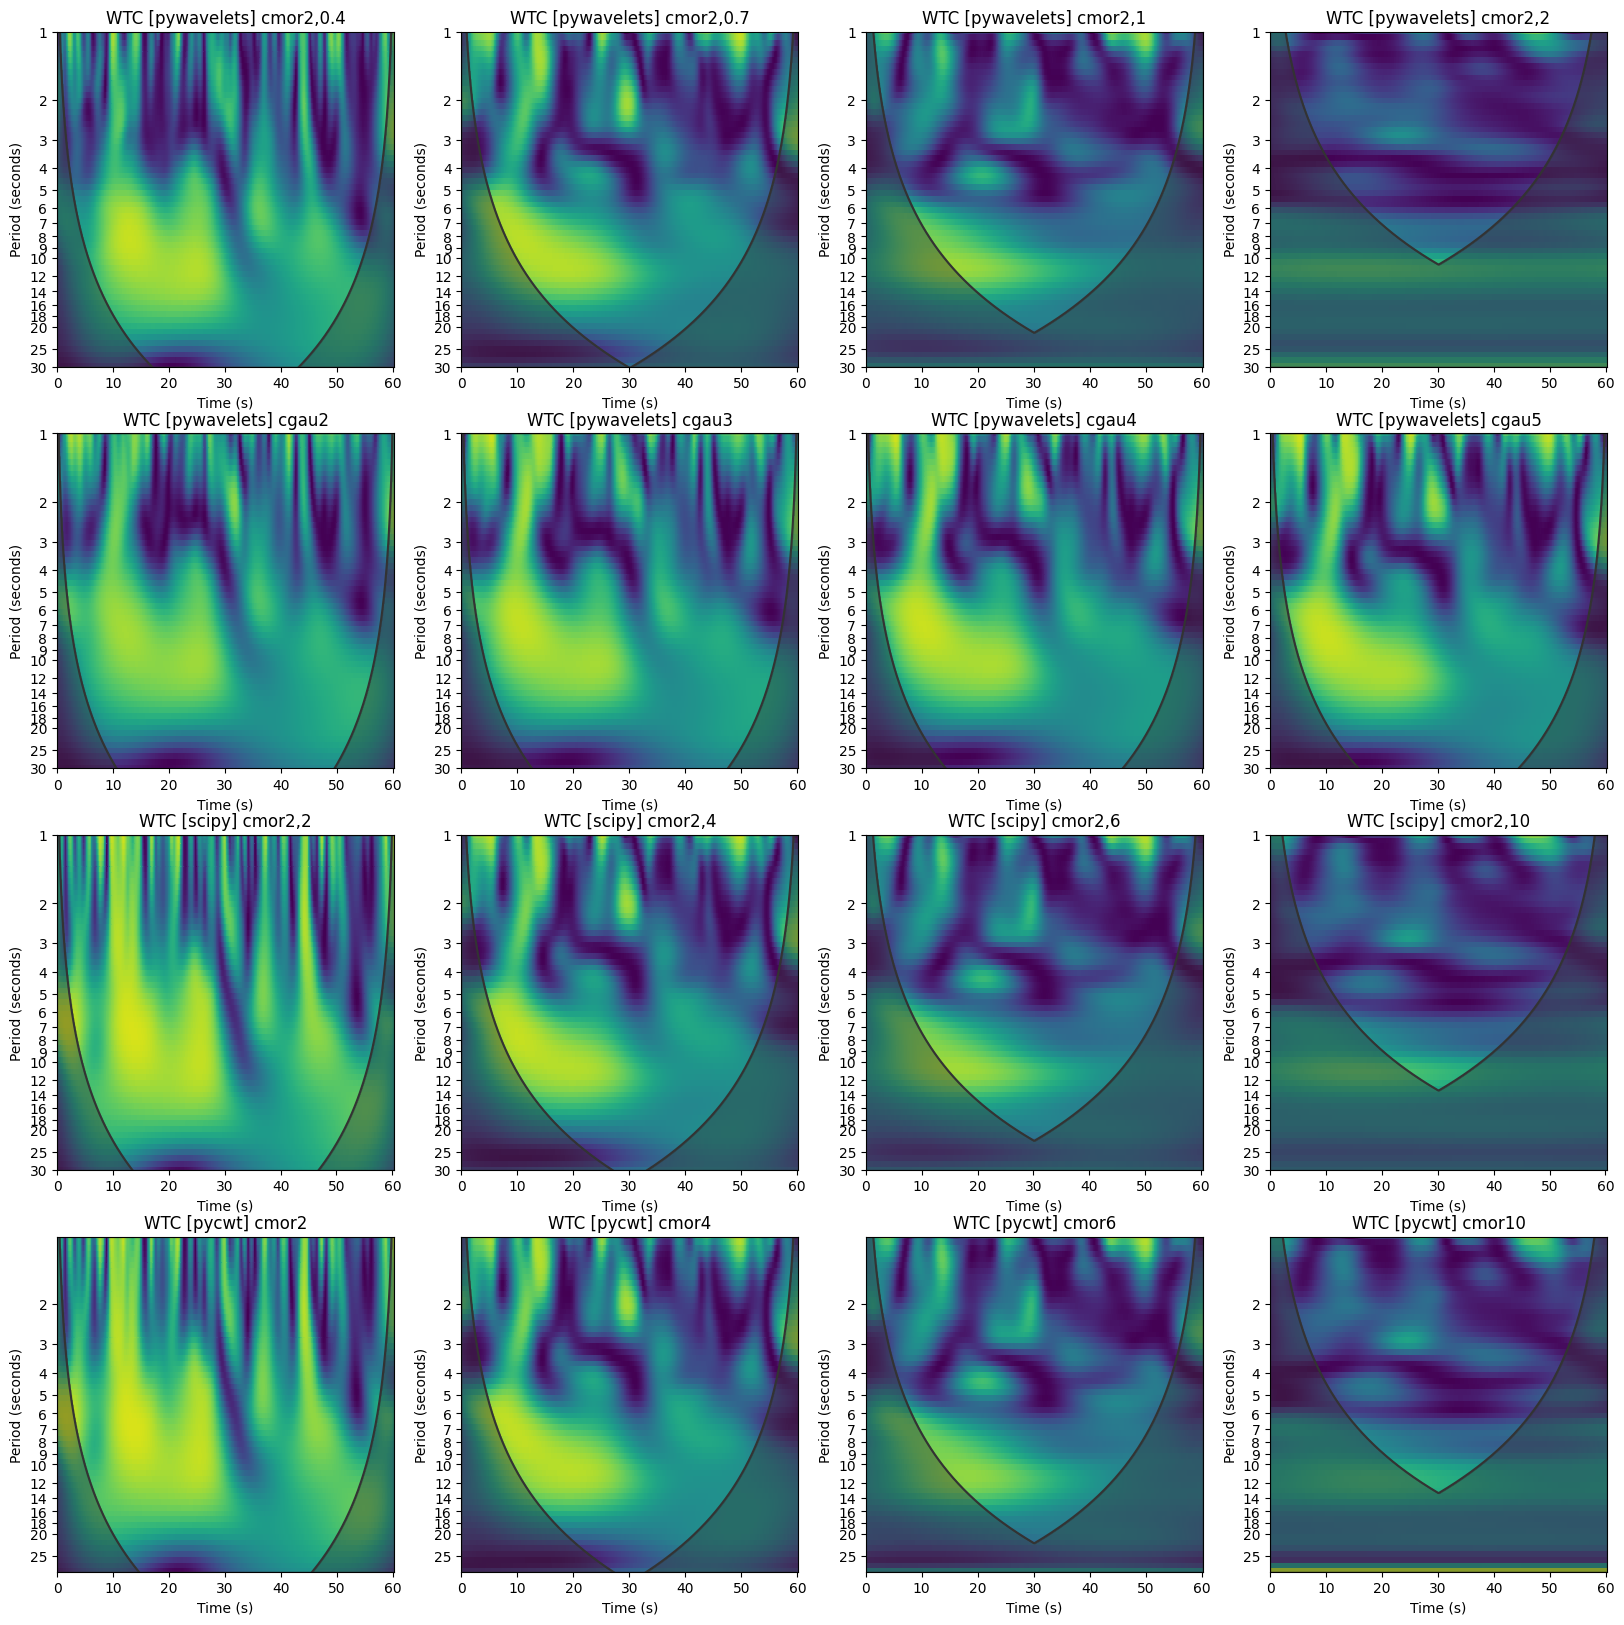

In [12]:
for wavelet, ax in wavelets_plot_iterator():
    wtc = wavelet.wtc(pair)
    wtc.plot(ax=ax, show_colorbar=False)
    ax.set_title(f'WTC [{wavelet.wavelet_library}] {wavelet.wavelet_name}')


## Time and frequency segmentation

When doing statistical analysis, multiple recordings of dyads are necessary. For each recording, a set of tasks are usually given, and can be recovered by events in the fNIRS recording file. 

These tasks may be recurring tasks, and have a different duration each time. A robust analysis should weight each recording by its duration.

Also, recordings can present a number of signal issues, either motion artifacts that cannot be filtered, or a connectivity failing on a specific channel, to name a few. To avoid excluding channels with punctual invalid data, a signal on a channel can be splitted in segments and the WTC will be computed to the matching segment of other channels. This will result of multiple segments of smaller duration. We also need to weight accordingly.

It can also be useful to split the resulting data into periods slices, to find the most "coherent" period ranges.

In order to have a balanced weight and period slices, once the WTC has been computed on a channel pair, we can split the WTC matrix in a grid.

The figure below explicitly shows the grid for a computed WTC.

Text(0.5, 0.98, 'Grid pattern with bin_seconds=10, period_cuts=[5, 10]')

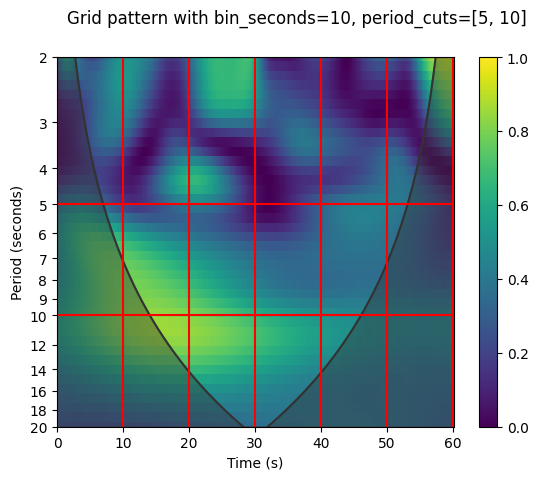

In [13]:
wavelet = PywaveletsWavelet(wavelet_name='cmor2,1')
bin_seconds = 10
period_cuts = [5, 10]
dyad = fnirs.Dyad(subject1, subject2)
dyad.compute_wtcs(wavelet=wavelet, ch_match='S1_D1 hbo', bin_seconds=bin_seconds, period_cuts=period_cuts, verbose=False)

wtc = dyad.wtcs[0]
fig = wtc.plot()
for time_cut in np.arange(0, max(wtc.times), bin_seconds):
    plt.axvline(x=time_cut, color='red')

for period_cut in period_cuts:
    plt.axhline(y=period_cut, color='red')

fig.suptitle(f'Grid pattern with bin_seconds={bin_seconds}, period_cuts={period_cuts}')


Each bin correspond to one row in the resulting pandas dataframe. Bins with more than 50% of their area in the cone of influence will be excluded by setting `NaN` in the coherence. The `coherence_masked` correspond to the ratio of area that is subject to artifacts

In [14]:
dyad.df[['bin', 'coherence', 'coherence_masked', 'bin_time_range', 'bin_period_range']]


,bin,coherence,coherence_masked,bin_time_range,bin_period_range
0,0,0.314823,0.461851,0-10,2.0-4.8
1,1,NaN,0.929654,0-10,5.1-9.8
2,2,NaN,1.000000,0-10,10.4-20.0
3,3,0.237143,0.000000,10-20,2.0-4.8
4,4,0.585320,0.111472,10-20,5.1-9.8
5,5,NaN,0.870130,10-20,10.4-20.0
6,6,0.396268,0.000000,20-30,2.0-4.8
7,7,0.462345,0.000000,20-30,5.1-9.8
8,8,0.648743,0.243506,20-30,10.4-20.0
9,9,0.208694,0.000000,30-40,2.0-4.8


# Coherence on multiple channel pairs

## Exploring the impact of Wavelet parameters on coherence

It is interesting to note that the current litterature on fNIRS hyperscanning uses a set of parameters for computing the Wavelet Transform Coherence (WTC) that has been established more than 20 years ago in the field of geophysics. The excellent article "A Practical Guide to Wavelet Analysis" from Terrence and Compo (1998) is foundational on the subject.

In order to validate that these parameters are indeed fit for fNIRS Inter Brain Synchrony (IBS) analysis using the WTC strategy analysis, we suggest here a way to explore the impact of these parameters on the IBS research.

Here is an example of how to compare the impact of wavelet parameters on the coherence results.

The code below defines multiple wavelets with different parameters. For each wavelet, it computes the WTC on a list of intra-subjects.

This is an example to serve as a starting point for a real analysis. A complete analysis would compute the WTC on more dyads and compare the statistical significance of the coherence given different set of parameters.

Considered parameters:

* Wavelet family (Complex Morlet and Complex DOG)
* Wavelet center frequency
* Wavelet bandwidth (Morlet only)
* Smoothing window size

There are mathematical imperatives that are not taken into consideration in the following list of wavelet parameters, and we recommend a careful review of wavelet analysis litterature before selecting the parameter pairs and drawing conclusions.


In [22]:

wavelet_kwargs = dict(periods_range=(1, 30))
wavelets = [
    PywaveletsWavelet(wavelet_name='cmor1,1', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cmor2,1', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cmor3,1', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cmor4,1', **wavelet_kwargs),

    PywaveletsWavelet(wavelet_name='cmor2,0.5', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cmor2,0.8', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cmor2,1', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cmor2,1.5', **wavelet_kwargs),

    PywaveletsWavelet(wtc_smoothing_win_size=0.001, **wavelet_kwargs),
    PywaveletsWavelet(wtc_smoothing_win_size=0.1, **wavelet_kwargs),
    PywaveletsWavelet(wtc_smoothing_win_size=0.6, **wavelet_kwargs),
    PywaveletsWavelet(wtc_smoothing_win_size=1, **wavelet_kwargs),

    PywaveletsWavelet(wavelet_name='cgau2', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cgau3', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cgau4', **wavelet_kwargs),
    PywaveletsWavelet(wavelet_name='cgau5', **wavelet_kwargs),
]

dyads = []
tasks = [('sample', 60, 120)]
processor = fnirs.MnePreprocessorBasic()
bin_seconds = 10
period_cuts = [5, 10]
n_dyads = 3
for wavelet in wavelets:
    for i in np.arange(0, n_dyads):
        file_path1 = file_paths[i*2]
        file_path2 = file_paths[i*2+1]
        #print(f'WTC "{wavelet.wavelet_name}" on file "{file_path1}" and {file_path2}')
        # clear previous cache from loop
        wavelet.clear_cache()
        subject1 = fnirs.Subject(tasks_time_range=tasks, label='subject1').load_file(file_path1, processor)
        subject2 = fnirs.Subject(tasks_time_range=tasks, label='subject2').load_file(file_path2, processor)
        dyad = fnirs.Dyad(subject1, subject2, label=f'{subject1.label}-{subject2.label} [{wavelet.wavelet_library}] {wavelet.wavelet_name}')
        dyad.compute_wtcs(wavelet=wavelet, ch_match='hbo', bin_seconds=bin_seconds, period_cuts=period_cuts, verbose=False)
        dyads.append(dyad)



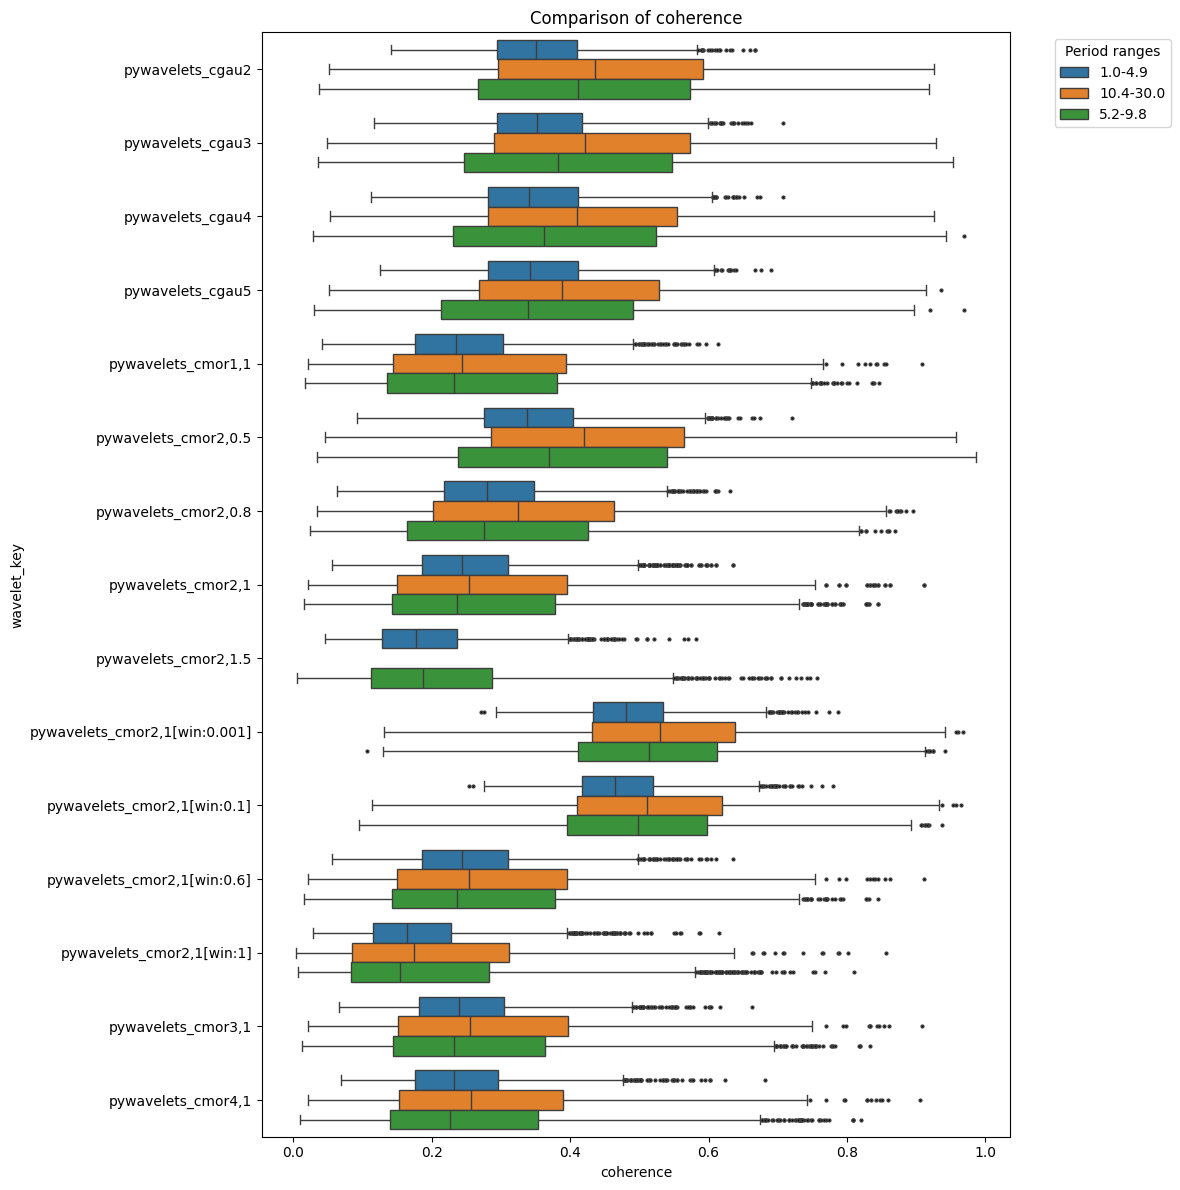

In [23]:

df = CoherenceDataFrame.concat([dyad.df for dyad in dyads])

plt.figure(figsize=(12, 12))

df['wavelet_key'] = df['wavelet_library'].astype(str) + ['_']*df.shape[0] + df['wavelet_name'].astype(str)
df['wavelet_key'] = df['wavelet_key'].astype('category')

flierprops = {"marker": ".", "markerfacecolor": "black", "markersize": 4}

sns.boxplot(data=df, y='wavelet_key', x='coherence', hue='bin_period_range', orient='h', flierprops=flierprops)

# Customize the plot
plt.legend(title='Period ranges', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Comparison of coherence')
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

